# Exploratory Data Analysis (EDA)

## Installing and Importing Libraries


In [ ]:
# Get the scripts from remote source
!git clone https://github.com/mlgomez0/Health_Therapist
!mv Health_Therapist/backend/ml_models/modules .
!mv Health_Therapist/backend/ml_models/datasets .
!mv Health_Therapist/requirements.txt .
!rm -rf Health_Therapist

Cloning into 'Health_Therapist'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 136 (delta 43), reused 87 (delta 15), pack-reused 0
Receiving objects: 100% (136/136), 2.88 MiB | 6.53 MiB/s, done.
Resolving deltas: 100% (43/43), done.
mv: cannot move 'Health_Therapist/backend/ml_models/modules' to './modules': Directory not empty
mv: cannot move 'Health_Therapist/backend/ml_models/datasets' to './datasets': Directory not empty


In [ ]:
from IPython.display import clear_output

!pip install -r requirements.txt

clear_output()

In [16]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline

## Exploring the Dataset

In [18]:
df = pd.read_csv('datasets/dataset.csv')
df.head()

,Context,Response
0,i am going through some things with my feeling...,if everyone thinks you are worthless then mayb...
1,i am going through some things with my feeling...,hello and thank you for your question and seek...
2,i am going through some things with my feeling...,first thing i would suggest is getting the sle...
3,i am going through some things with my feeling...,therapy is essential for those that are feelin...
4,i am going through some things with my feeling...,i first want to let you know that you are not ...


### Text Length Analysis

In [ ]:
df.shape

(2747, 2)

In [ ]:
df["ContextLength"] = df["Context"].apply(lambda x: len(x))
df["ResponseLength"] = df["Response"].apply(lambda x: len(x));


In [ ]:
df.dtypes

Context           object
Response          object
ContextLength      int64
ResponseLength     int64
dtype: object

In [ ]:
df.describe()

,ContextLength,ResponseLength
count,2747.000000,2747.000000
mean,284.794321,1008.037859
std,255.772193,936.542250
min,23.000000,9.000000
25%,144.000000,521.000000
50%,232.000000,815.000000
75%,338.000000,1244.500000
max,2645.000000,25952.000000


In [ ]:
def plot_all_features(df, columns):
  fig = plt.figure(figsize=(18, 9))
  rows, cols = 1, 2
  for i in range(1, rows * cols + 1):
    col = columns[i - 1]
    fig.add_subplot(rows, cols, i)
    sns.histplot(df[col], bins=10, kde=True, color='skyblue')
    plt.title(f'Distribution with Mean, Median, and Mode for {col}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    counts, bin_edges = np.histogram(df[col], bins=10)
    bin_edges = np.round(bin_edges, 2)
    col_mean = np.mean(df[col])
    col_median = np.median(df[col])
    col_mode = mode(df[col])[0]
    plt.axvline(col_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {col_mean:.2f}')
    plt.axvline(col_median, color='green', linestyle='dashed', linewidth=2, label=f'Median: {col_median:.2f}')
    plt.axvline(col_mode, color='orange', linestyle='dashed', linewidth=2, label=f'Mode: {col_mode:.2f}')
    plt.xticks(bin_edges)
    plt.legend()

  plt.subplots_adjust(hspace=0.5)

  plt.show()

In [ ]:
columns = ['ContextLength', 'ResponseLength']

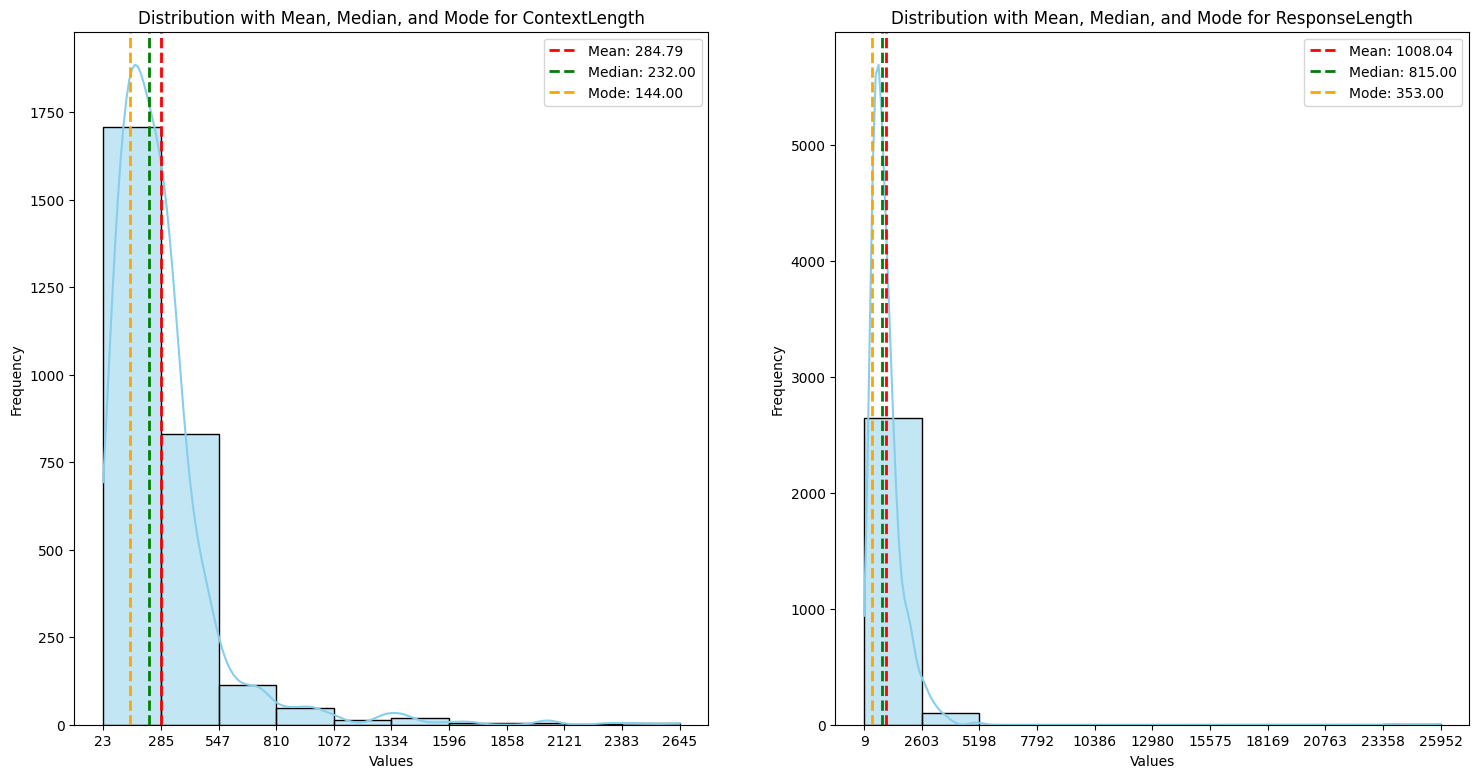

In [ ]:
plot_all_features(df, columns)

- The length of the text presents right-skewed distributions.
- We can see that the content length of the responses is higher than that of the context.

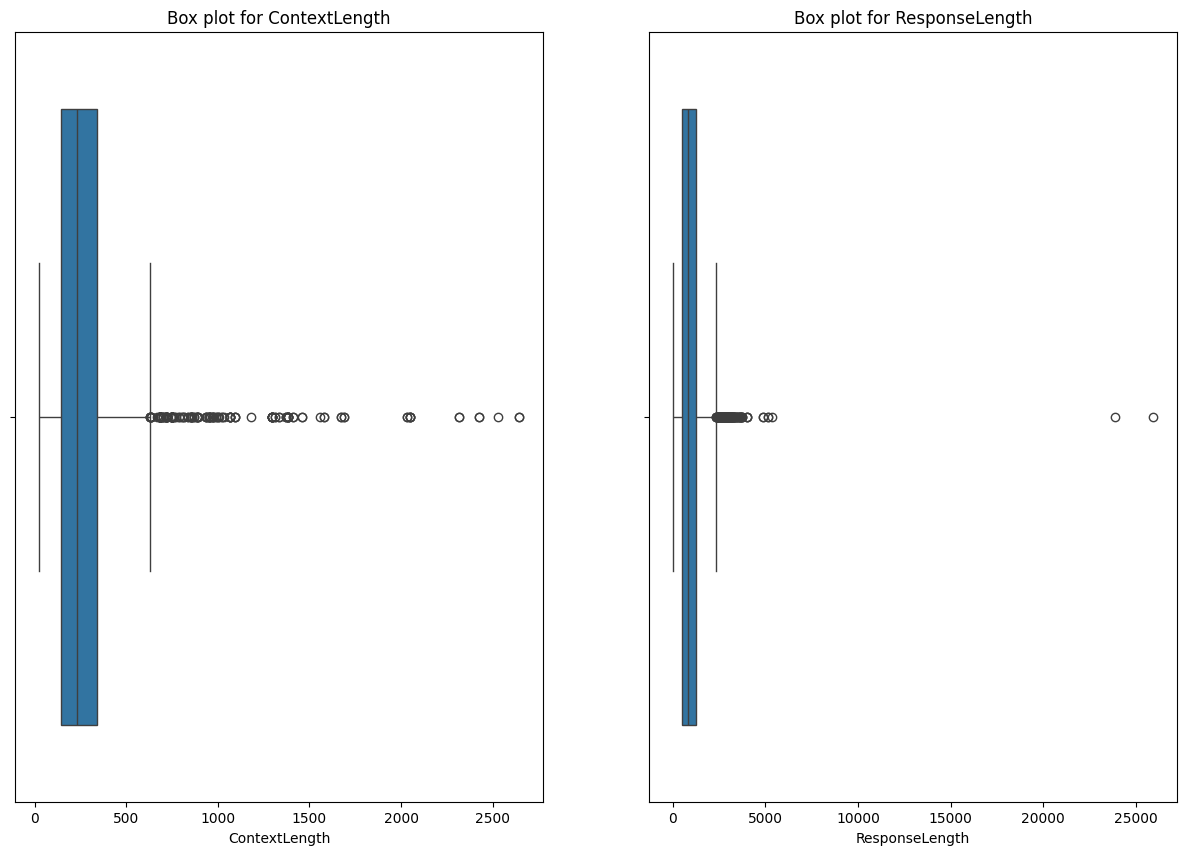

In [ ]:
# Checking Boxplots

rows, cols = 1,2
fig = plt.figure(figsize=(15,10))

for i, col in enumerate(columns):
  fig.add_subplot(rows, cols, i+1)
  sns.boxplot(data=df[col], orient='h')
  plt.title(f"Box plot for {col}")

plt.subplots_adjust(hspace=0.5)
plt.show()

Note:

We can see the presence of text length outliers. Because of that, we need to consider whether the model presents any skew learning favoring responses into some specific length range during model evaluation.

## Unigrams and Bigrams Analysis

In [ ]:
# Analyze unigrams
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Context'])
unigram_freq_c = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Response'])
unigram_freq_r = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)


# Analyze bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X2 = bigram_vectorizer.fit_transform(df['Context'])
bigram_freq_c = pd.DataFrame(X2.toarray(), columns=bigram_vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

# Analyze bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X2 = bigram_vectorizer.fit_transform(df['Response'])
bigram_freq_r = pd.DataFrame(X2.toarray(), columns=bigram_vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

In [ ]:
# Plotting unigrams

def plot_ngrams(data, columns, label):
  fig = plt.figure(figsize=(12, 6))
  rows, cols = 1, 2
  for i in range(1, rows * cols + 1):
    col = columns[i - 1]
    fig.add_subplot(rows, cols, i)
    sns.barplot(x=data[i-1].head(20).values, y=data[i-1].head(20).index, orient='h', palette='pastel')
    plt.title(f'Top 20 {label} Frequency for {col}')
    plt.xlabel('Frequency')
    plt.ylabel(label)
    plt.xticks(rotation=90)
    fig.tight_layout()

  plt.show()

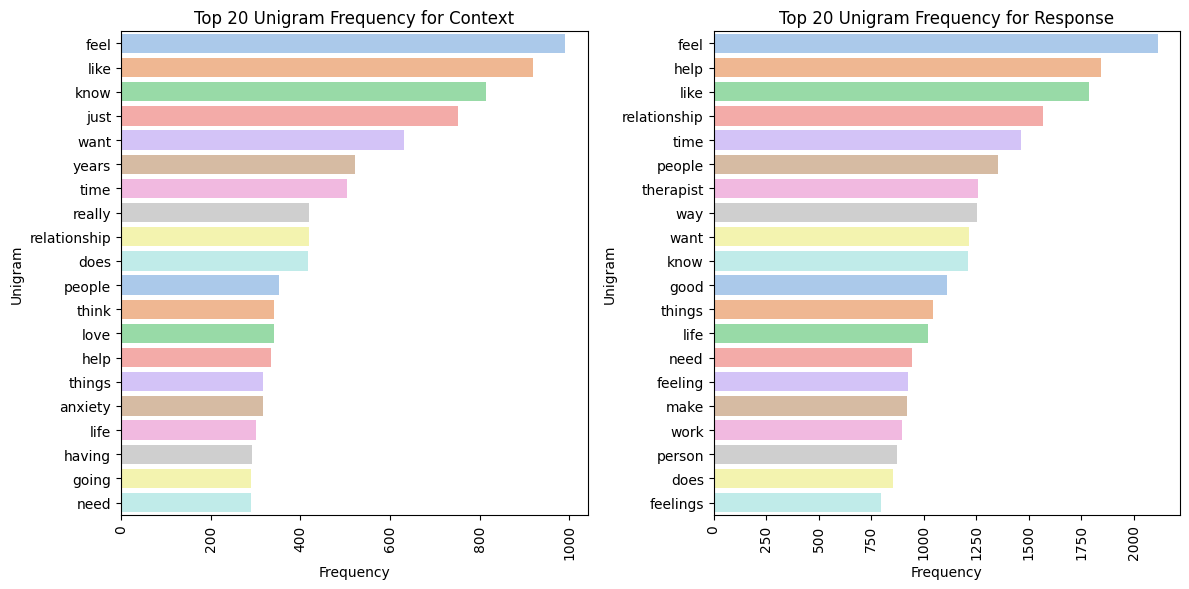

In [ ]:
plot_ngrams([unigram_freq_c, unigram_freq_r], ['Context', 'Response'], "Unigram");

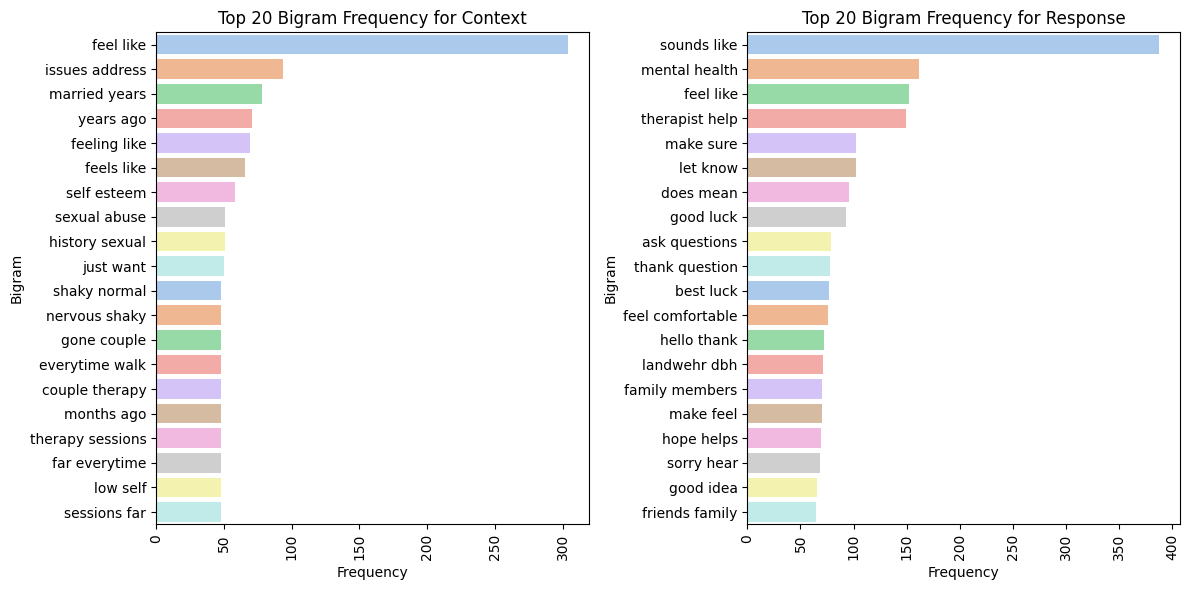

In [ ]:
plot_ngrams([bigram_freq_c, bigram_freq_r], ['Context', 'Response'], "Bigram")

Note:

- Looking at the word frequency in the "Context" and "Response" columns helped us understand the data's coherence. In conclusion, we see the words are in line with the type of issues someone could bring in a therapy section, such as relationships, anxiety, feelings like sexual abuse, etc. Furthermore, for the words we found in "Response", we can see words consistent with what a therapist's answer could talk about. We can see words like feel comfortable, good idea, friends, family, etc.

## Word Cloud

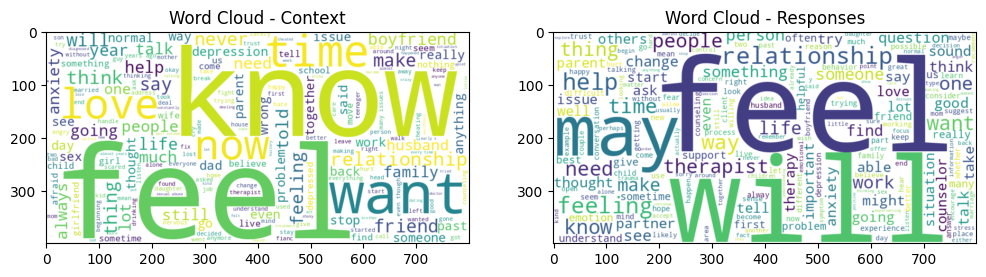

In [ ]:
# dividing between negative and non-negative text
context_txt = ' '.join(df['Context'])
response_txt = ' '.join(df['Response'])

wordcloud_context = WordCloud(width=800, height=400, background_color='white').generate(context_txt)
wordcloud_response = WordCloud(width=800, height=400, background_color='white').generate(response_txt)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_context, interpolation='bilinear')
plt.title('Word Cloud - Context')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_response, interpolation='bilinear')
plt.title('Word Cloud - Responses')

plt.show()

Note:

-  This Word Cloud gives us a better view of the textual data content, again in line with what we expect in mental therapy sections.

## Topic Modeling

In [19]:
# We will use topicwizard

vectorizer = CountVectorizer(min_df=10, max_df=0.5, stop_words="english") # To transform the text into a numerical representation
topic_model = NMF(n_components=10)

topic_pipeline = Pipeline(
    [
        ("vectorizer", vectorizer),
        ("topic_model", topic_model),
    ]
)

In [20]:
df['Text'] = df['Context'] + ' ' + df['Response'] # Creating a column with all the text of the conversations

In [21]:
topic_pipeline.fit(df['Text'])

Pipeline(steps=[('vectorizer',
                 CountVectorizer(max_df=0.5, min_df=10, stop_words='english')),
                ('topic_model', NMF(n_components=10))])

In [22]:
import topicwizard

In [23]:
# Topic modeling for Context
topicwizard.visualize(corpus=df['Text'], model=topic_pipeline)

Preprocessing
Inferring topical content for documents.


<IPython.core.display.Javascript object>

Open in browser:


<IPython.core.display.Javascript object>

<Thread(Thread-148 (_run_silent), stopped 133879014860352)>

The topic modeling give us powerfull insights on the topics present in the mental health dataset:

Some of the topics are:

- Work-Life Balance (0_work_life_time_person)
- Anxiety and Depression (7_anxiety_depression_new_job)
- Negative Thoughts (4_thoughts_negative_scary)
- Romantic Relationships (2_relationship_partner_want_boyfriend)
- Parenthood (5_parents_know_want_does)
- People Feelings (6_people_things_want_feeling)
- Help With Depression (help_feelings_feeling_depression)
- Therapy and Therapist (3_therapist_therapy_know_client)
- Counseling Issues (9_issues_counseling_counselor_client)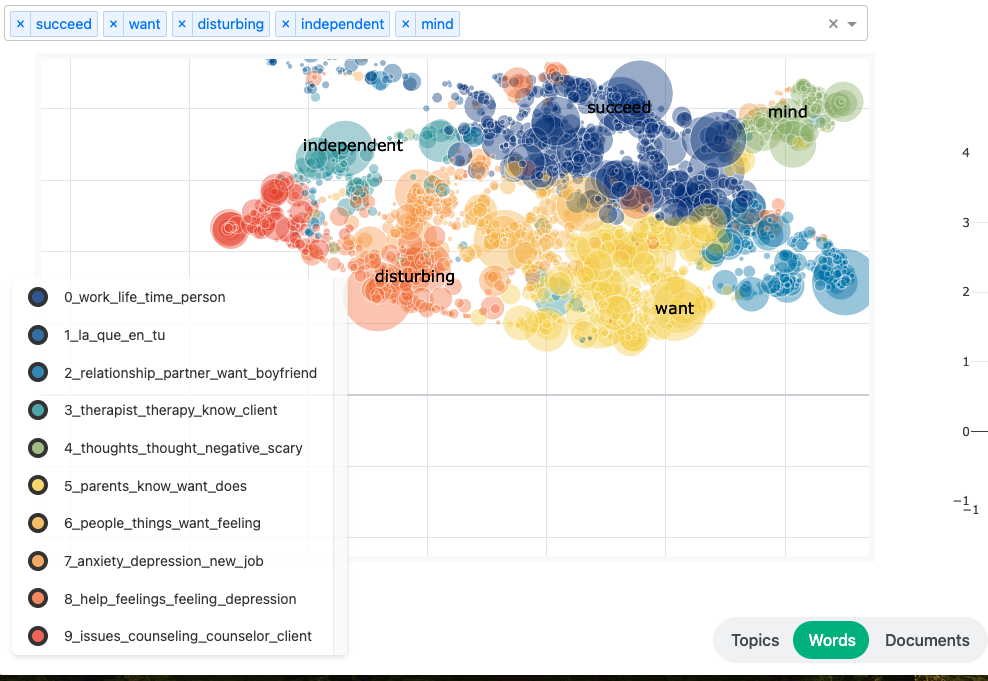

Visualizations:

- 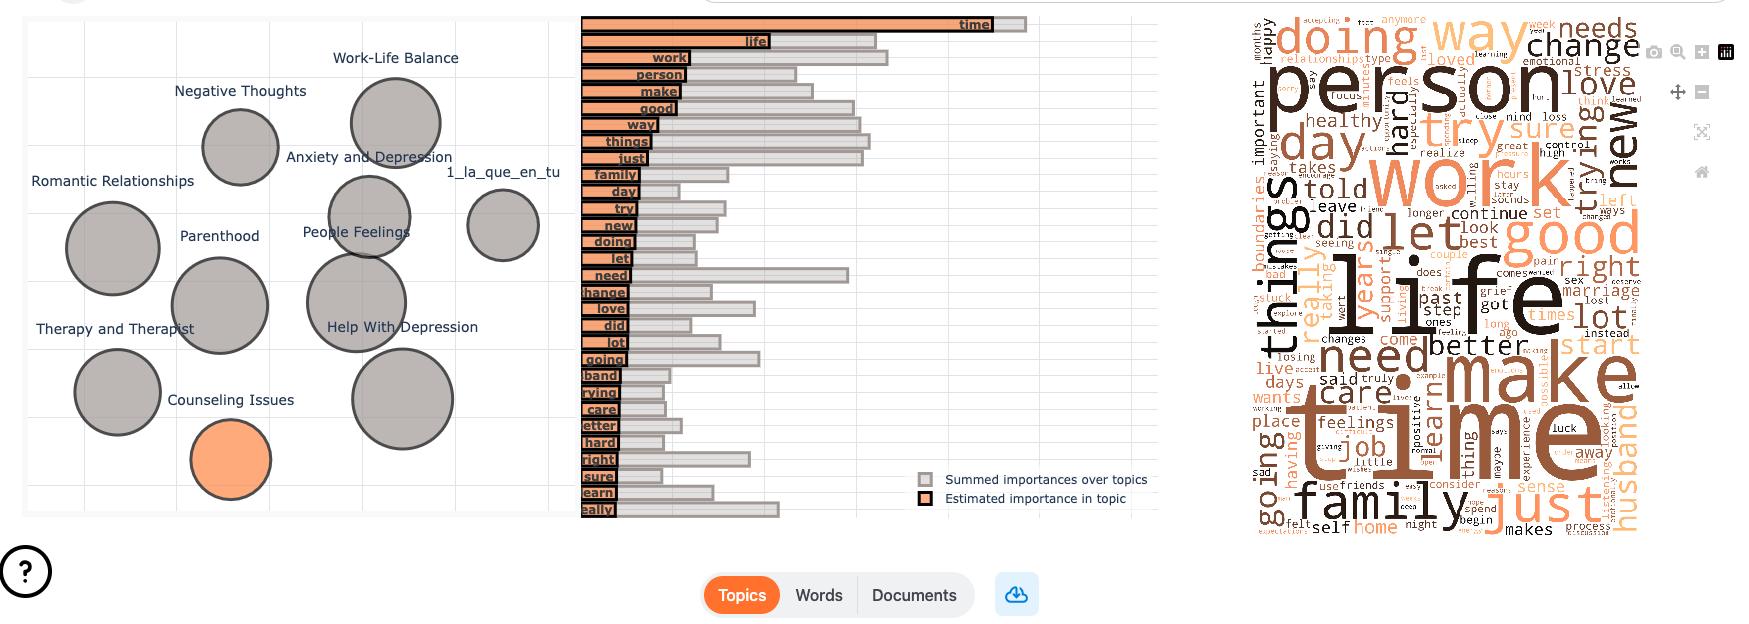




## Conclusion

### Understanding Outliers
- **Impact of Outliers:** It is important to assess how the presence of outliers in the textual data length may impact the model's performance. To do this, consider conducting experiments to evaluate the model's responses for both long and short "Context" inputs. This can help determine if the model handles varying lengths effectively and whether any adjustments are needed to improve performance on extreme cases.

### Language Inspection
- **Content Alignment:** By using tools such as WordCloud to inspect the language used in "Context" and "Response", we can verify that the dataset's content aligns with the project's objectives. The analysis shows that the language correlates well with what is expected in mental therapy sessions. This ensures that the dataset is appropriate for training a model intended to simulate or assist in therapeutic conversations.

### Topic Identification

- **Topic Relevance**: The identification of key topics within the dataset provides valuable insights into the types of conversations the model will encounter. This understanding will guide us in tailoring the model's training to focus on these prevalent themes, ensuring that it learns effectively from the data. Consequently, the model will be better equipped to generate relevant and coherent responses in conversations related to mental therapy.
